# Постановка задачи

### Задача

- Построение модели, которая предсказывает сколько пассажиров будут пользоваться метро в ближайшее время

### Описание данных

**Источник данных:** https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

#  Загрузка библиотек и функций

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, \
    median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [275]:
from sktime.utils.plotting import plot_series

# Загрузка данных

In [276]:
df = pd.read_csv('../input/data/Metro_Interstate_Traffic_Volume.csv')

In [277]:
df = df[['date_time','traffic_volume', 'holiday', 'temp']]
df.head()

,date_time,traffic_volume,holiday,temp
0,2012-10-02 09:00:00,5545,None,288.28
1,2012-10-02 10:00:00,4516,None,289.36
2,2012-10-02 11:00:00,4767,None,289.58
3,2012-10-02 12:00:00,5026,None,290.13
4,2012-10-02 13:00:00,4918,None,291.14


 - Данные загрузились успешно

# 1. General view

## 1.1 Типы данных

In [278]:
def display_dtypes(df):
    df_local = df
    df_tmp = df_local#[[i for i in df_local.columns if 'datetime' in i]]

    # Обзор намеков на типы признаков
    unique_values = df_tmp.nunique().sort_values(ascending=False)
    unique_values = pd.DataFrame(unique_values, columns = ['Колич. уник. значений'])

    # Довать процентовку
    unique_values['Доля в %'] = (unique_values['Колич. уник. значений']/df_tmp.shape[0])*100
    unique_values = pd.concat([unique_values, pd.DataFrame(df_tmp.dtypes, columns=['dtype'])], axis=1) 
    display(unique_values)
    
display_dtypes(df)

,Колич. уник. значений,Доля в %,dtype
date_time,40575,84.173513,object
traffic_volume,6704,13.907560,int64
temp,5843,12.121401,float64
holiday,12,0.024894,object


**Заключение**

- **date_time** - тип данных потенциально *date_time*; Доля уникальных значений намекает на наличие дубликатов по временной шкале.

## 1.2. Проверка наличия дыр в данных

Проверим данные на наличии больших пропусков

In [279]:
import missingno as msno


# Процентный список пропущенных значений
def scan_miss_val(df: pd.DataFrame) -> pd.DataFrame:
    '''
    :param df:
    :return: На выходе столбец значений =(% NAN) в признаке.
    '''
    # ___init___
    miss_val_df = pd.DataFrame()
    NA_present = 0

    # Обработка каждого столбца отдельно
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        temp = pd.DataFrame([round(pct_missing * 100)], columns=['% miss'], index=[col])
        temp['cnt'] = df[col].isnull().sum()

        miss_val_df = pd.concat([miss_val_df, temp], axis=0)

        if (pct_missing != 0) & (NA_present == 0):
            NA_present = NA_present + 1

    # Построение Тепловой карты пропущенных значений
    if NA_present != 0:
        msno.matrix(df, labels=True, sort="descending")

    return miss_val_df.sort_values(by='% miss')

scan_miss_val(df)

,% miss,cnt
date_time,0,0
traffic_volume,0,0
holiday,0,0
temp,0,0


**Заключение**

- в данных отсутствуют пропуски

##  1.3. Области допустимых значений признаков (поиск ошибок в данных).

Проверим, все ли значения признаков входят в допустимые области значений

In [280]:
df.describe().drop(['count', 'std', 'mean'], axis=0)

,traffic_volume,temp
min,0.0,0.000
25%,1193.0,272.160
50%,3380.0,282.450
75%,4933.0,291.806
max,7280.0,310.070


In [281]:
df['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

**Заключение**

- в данных отсутствуют ошибки записей

## 1.4 Наличие дубликатов

In [282]:
# Сканирование на наличие дубликатов
columns_to_concider = df.columns
df_duplicated = df.duplicated(subset=columns_to_concider)

n_duplicates = df_duplicated.sum()
print('Number of duplicates = ', n_duplicates)

Number of duplicates =  7551


In [283]:
# Сканирование на наличие дубликатов
columns_to_concider = df.columns
df_duplicated = df.duplicated(subset='date_time')

n_duplicates = df_duplicated.sum()
print('Number of duplicates = ', n_duplicates)

Number of duplicates =  7629


**Замечание**

- как и ожидалось, в **date_time** имеется $7629$ дубликатов;
- если смотреть по всем признакам, то дубликатов меньше -  $7551$.

Таким образом можно сделать вывод, что не все наблюдения-дубликаты по **date_time** являются полными дубликатами наблюдений.

**Посмотрим на несовпадающие дубликаты:**

In [284]:
df_duplicated = df.duplicated(subset=columns_to_concider, keep=False)
subset_1  = set(df[df_duplicated==True].index)
df_duplicated = df.duplicated(subset='date_time', keep=False)
subset_2  = set(df[df_duplicated==True].index)

In [285]:
df.loc[subset_2.difference(subset_1)]

,date_time,traffic_volume,holiday,temp
13824,2014-04-21 15:00:00,5955,None,292.36
13825,2014-04-21 15:00:00,5955,None,292.03
13826,2014-04-21 16:00:00,6447,None,291.41
13827,2014-04-21 16:00:00,6447,None,290.51
23590,2016-05-24 10:00:00,4652,None,294.56
...,...,...,...,...
11725,2014-01-24 16:00:00,4880,None,272.15
11726,2014-01-24 16:00:00,4880,None,272.32
24552,2016-06-29 20:00:00,2581,None,298.08
24553,2016-06-29 20:00:00,2581,None,297.35


**Замечание**

- в глаза бросается, что отобранные "потенциальные наблюдения-дубликаты" отличаются между собой только по признаку **temp**

**Проверим это наблюдение:**

In [286]:
df_duplicated = df.duplicated(subset=['date_time', 'traffic_volume', 'holiday'], keep=False)
subset_3  = set(df[df_duplicated==True].index)

In [287]:
df.loc[subset_2.difference(subset_3)]

,date_time,traffic_volume,holiday,temp


**Замечание**

- Подтвердилось наше наблюдение, что различие "потенциальных наблюдений-дубликатов" между собой заключается исключительно по признаку **temp**.
- Осталось убедиться, что по признаку **temp** они различаются незначительно

**Проверим это:**

array([[<AxesSubplot:title={'center':'temp'}>]], dtype=object)

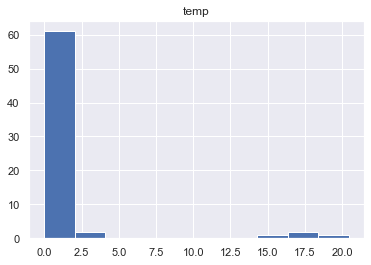

In [288]:
df_temp = df.loc[subset_2.difference(subset_1)][['date_time', 'temp']].copy()
df_temp_scored = df_temp.groupby(by='date_time').agg(lambda x: max(x)- min(x))

df_temp_scored.hist()

In [289]:
df[df['date_time'].isin(list(df_temp_scored[df_temp_scored['temp']>5].index))]

,date_time,traffic_volume,holiday,temp
11543,2014-01-17 03:00:00,395,None,276.793
11544,2014-01-17 03:00:00,395,None,258.960
11546,2014-01-17 06:00:00,5441,None,276.793
11547,2014-01-17 06:00:00,5441,None,256.360
11552,2014-01-17 12:00:00,5204,None,276.793
11553,2014-01-17 12:00:00,5204,None,260.180
11556,2014-01-17 16:00:00,6430,None,276.793
11557,2014-01-17 16:00:00,6430,None,261.000


## 1.5 Преобразование данных

Решение по дубликатам:
 - Возьмем среднее по признаку **temp** для каждой группы дубликатов;
 - Убедимся, что количество дубликатов по всем признаком совпадет с количеством дубликатов по признаку **date_time**;
 - Удалим дубликаты
 
Решение по типам данных:
 - Преобразование **date_time** в тип DateTime;
 - Трансформация датасета во временной ряд, путем назначения признака **date_time** в качестве **index**

### 1.5.1 Обрабатываем дубликаты

In [290]:
df['temp'] = df.groupby(by='date_time')['temp'].transform('mean')

In [291]:
# Сканирование на наличие дубликатов
columns_to_concider = df.columns
df_duplicated = df.duplicated(subset=columns_to_concider)

n_duplicates = df_duplicated.sum()
print('Number of duplicates = ', n_duplicates)

Number of duplicates =  7629


In [292]:
# Сканирование на наличие дубликатов
columns_to_concider = df.columns
df_duplicated = df.duplicated(subset='date_time')

n_duplicates = df_duplicated.sum()
print('Number of duplicates = ', n_duplicates)

Number of duplicates =  7629


In [293]:
origin_shape = df.shape[0]
df.drop_duplicates(inplace=True)
print(f'Изменение размерности:\n {origin_shape} -> {df.shape[0]}: удалено {origin_shape - df.shape[0]} наблюдений')

Изменение размерности:
 48204 -> 40575: удалено 7629 наблюдений


### 1.5.2 Обрабатываем date_time

In [294]:
df['date_time'] = pd.to_datetime(df['date_time'],
                                 format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

In [295]:
display_dtypes(df)

,Колич. уник. значений,Доля в %,dtype
date_time,40575,100.000000,datetime64[ns]
traffic_volume,6704,16.522489,int64
temp,5888,14.511399,float64
holiday,12,0.029575,object


In [296]:
df.index = df['date_time']
df.drop(columns=['date_time'], inplace=True)

In [297]:
df.head()

,traffic_volume,holiday,temp
date_time,,,
2012-10-02 09:00:00,5545,None,288.28
2012-10-02 10:00:00,4516,None,289.36
2012-10-02 11:00:00,4767,None,289.58
2012-10-02 12:00:00,5026,None,290.13
2012-10-02 13:00:00,4918,None,291.14


In [298]:
# Сохраним полученный датасет
df.to_pickle('../data/df_1.pkl')

# 2. Content view

Посмотрим на имеющиеся данные независимо друг от друга

In [299]:
from tqdm import tqdm

import math

## 2.1 Анализ распределений

In [300]:
def plot_numUFA(df: pd.DataFrame, num_columns: list=None):
    
    assert num_columns!=None, 'Не передан список числовых признаков'

    skewness_list = df[num_columns].skew()
    
    subplot_cnt = len(num_columns)*3
    
    
    n_col = 3
    if len(num_columns) <= n_col/3:
        n_col = 3
        n_row = 1
    else:
        n_row = math.ceil(subplot_cnt / n_col)
    

    fig, axes = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(n_col * 6, n_row * 6),
        gridspec_kw={"hspace": 0.4, "wspace": 0.2, "width_ratios": [0.8, 0.5, 1]},
    )
    axes = axes.flatten()
    i = 0
    for column in tqdm(num_columns):

         # __Распределение__
        ax = axes[i]
        sns.kdeplot(data=df, 
                    x=column, 
                    ax=ax, 
                    fill=False, 
                    alpha=0.9, 
                    legend=False, 
                    linewidth=3, 
                    palette = 'Set2',
                   )

        skewness = skewness_list[column]
        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[-1],
            f"skew: {skewness:.2f}",
            size=12,
            weight="bold",
        )
        i = i+1



        #__Бокс__
        ax = axes[i]
        sns.boxplot(
            data=df,
            #x="Churn",
            y=column,
            ax=ax,
            width=0.6,
            saturation=0.9,
            linewidth=0.9,
            palette='Set2',
        )

        i =i + 1



        # __Монотонность__
        df_local = df.copy()
        df_local = df_local.sort_values(by=column).reset_index(drop=True)
        ax = axes[i]
        sns.scatterplot(
            data=df_local, x=df_local.index, y=column,alpha=1, ax=ax, color='b', palette='Set2'
        )
        i = i+1

In [301]:
def plot_data(df):
    df.plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.show()

In [302]:
df = pd.read_pickle('../data/df_1.pkl')
df.head()

,traffic_volume,holiday,temp
date_time,,,
2012-10-02 09:00:00,5545,None,288.28
2012-10-02 10:00:00,4516,None,289.36
2012-10-02 11:00:00,4767,None,289.58
2012-10-02 12:00:00,5026,None,290.13
2012-10-02 13:00:00,4918,None,291.14


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


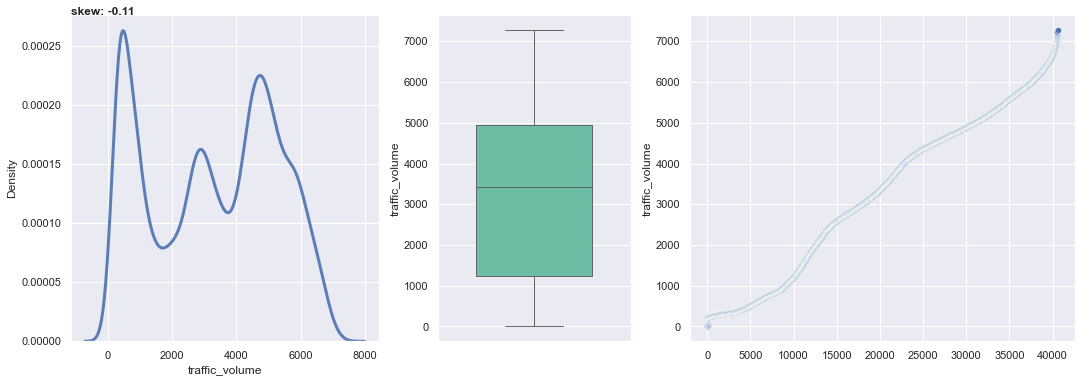

In [303]:
plot_numUFA(df, num_columns=['traffic_volume'])

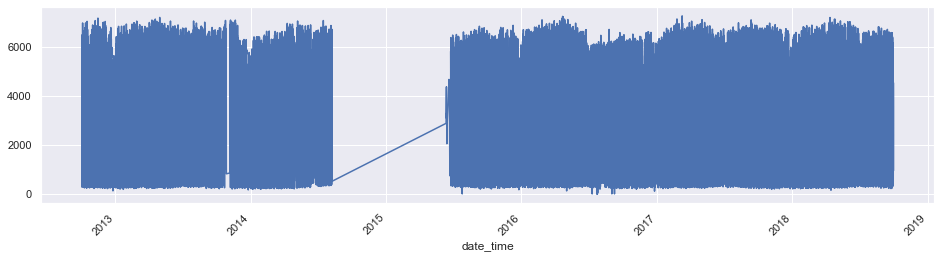

In [304]:
plot_data(df['traffic_volume'])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


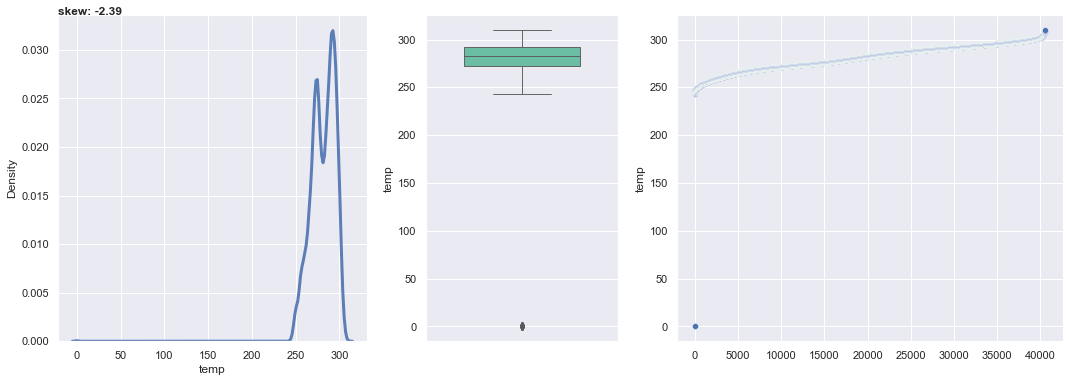

In [305]:
plot_numUFA(df, num_columns=['temp'])

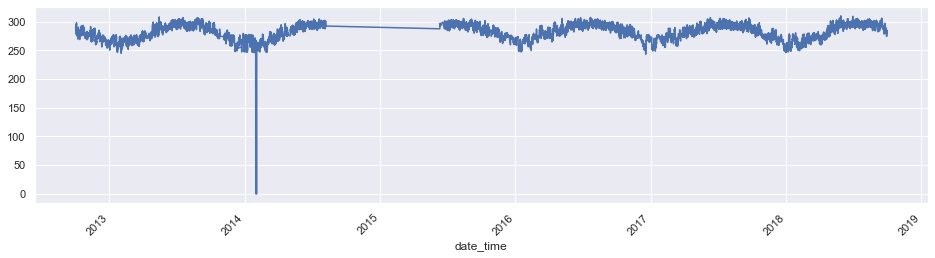

In [306]:
plot_data(df['temp'])

**Заключение**

- очевидно наличие выброса в признаке **temp**

## 2.2 Анадиз временной шкалы

Проверим равномерность временных интервалов

In [329]:
def plot_timeStamps(df):
    a=[]
    b=[]
    for x in range(0,df.shape[0]-1):
        b.append(df.index.values[x+1])
        a.append(df.index.values[x+1] - df.index.values[x])
        
    plot_data(pd.Series(a, index=b).dt.components['hours'])

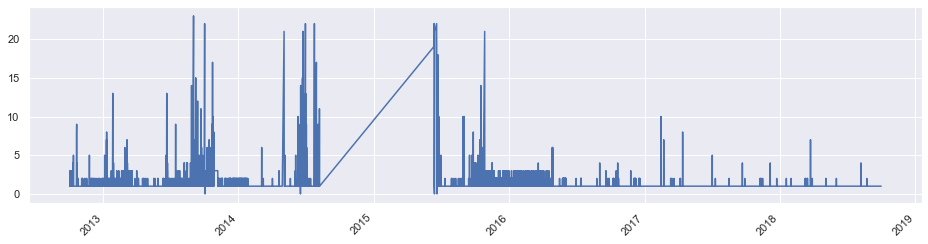

In [330]:
plot_timeStamps(df)

**Заключение**

- очевидно наличие неоднородности временных интервалов

## 2.3 Преобразование данных

### 2.3.1 Расширение временной шкалы

Сначала расширим временную шкалу, выравнивая временные интервалы

In [328]:
df_extended = pd.concat([pd.DataFrame(index=pd.date_range(start=df.index[0], end=df.index[-1], freq='h')), df], axis=1)
df_extended

,traffic_volume,holiday,temp
2012-10-02 09:00:00,5545.0,None,288.28
2012-10-02 10:00:00,4516.0,None,289.36
2012-10-02 11:00:00,4767.0,None,289.58
2012-10-02 12:00:00,5026.0,None,290.13
2012-10-02 13:00:00,4918.0,None,291.14
...,...,...,...
2018-09-30 19:00:00,3543.0,None,283.45
2018-09-30 20:00:00,2781.0,None,282.76
2018-09-30 21:00:00,2159.0,None,282.73
2018-09-30 22:00:00,1450.0,None,282.09


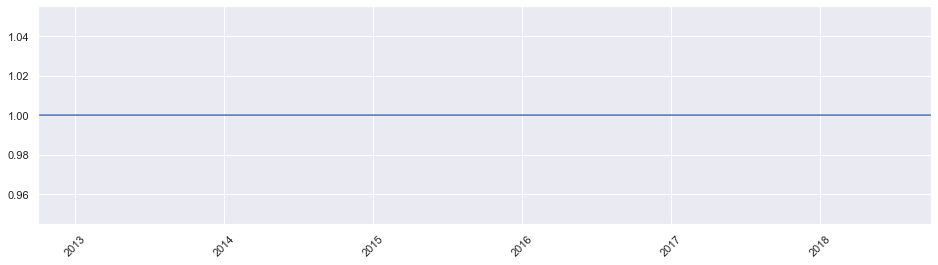

In [331]:
plot_timeStamps(df_extended)

- Видим, что неоднородность временных интервалом пропала

### 2.3.2 Заполнение пропусков

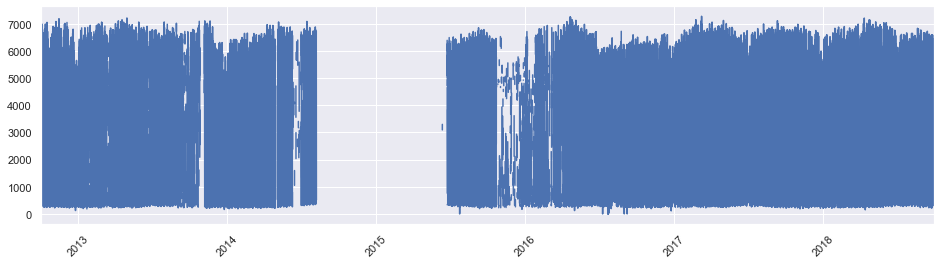

In [333]:
plot_data(df_extended['traffic_volume'])

- Как видим имеется значительный пробел в данных, который пришелся на 2014 - 2015 годы, который заполнять интерполяцией не лучший вариант. Более того, в конце 2015 года данные очень разреженные.
- Отбросим данные, полученные ранее 2016 года.

In [338]:
df_extended["year"] = df_extended.index.year.values

In [339]:
df_extended = df_extended[df_extended['year']>=2016]

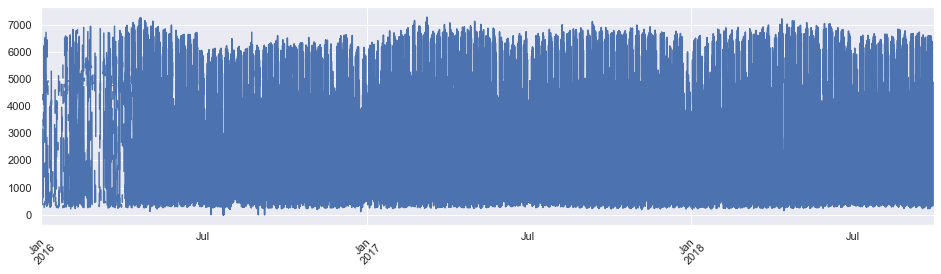

In [340]:
plot_data(df_extended['traffic_volume'])

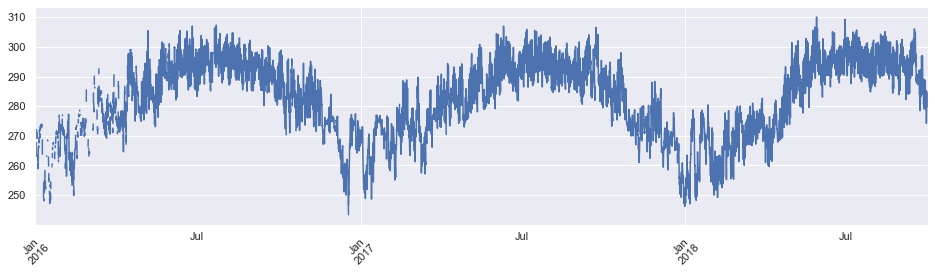

In [341]:
plot_data(df_extended['temp'])

С помощию интерполиции заполним пропущенные значения в признаках **traffic_volume** и **temp**

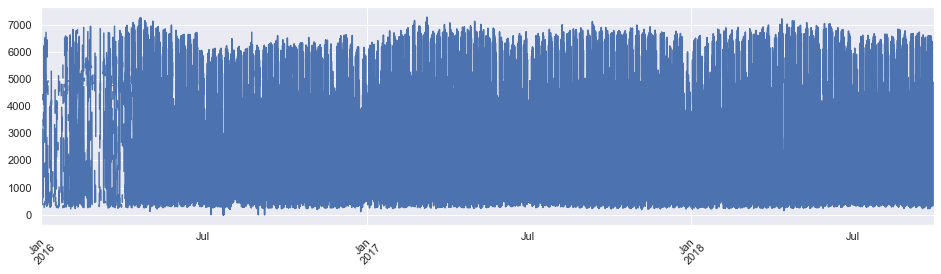

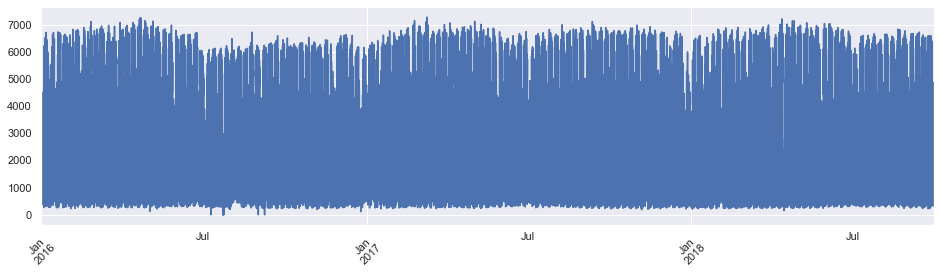

In [342]:
plot_data(df_extended['traffic_volume'])
df_extended['traffic_volume'] = df_extended['traffic_volume'].interpolate(method='polynomial', order=1)
plot_data(df_extended['traffic_volume'])

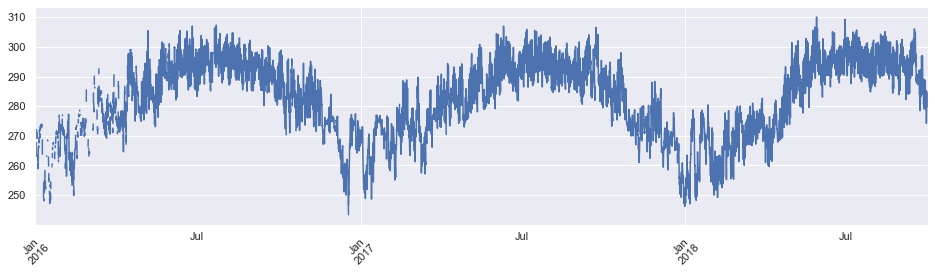

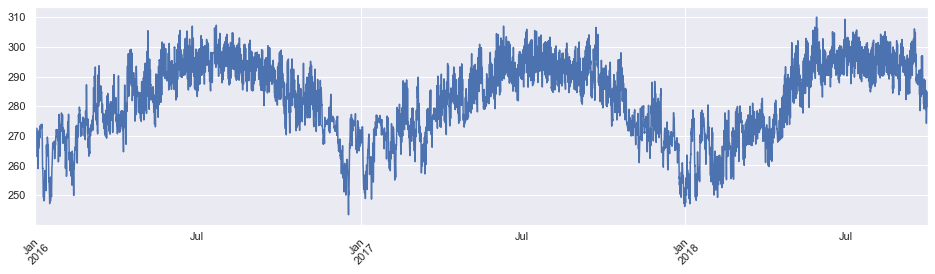

In [343]:
plot_data(df_extended['temp'])
df_extended['temp'] = df_extended['temp'].interpolate(method='polynomial', order=1)
plot_data(df_extended['temp'])

- Заполним пропуски в признаке **holiday** и расширим метку праздника на весь день (в настоящий момент метка присутствует только на нулевом часе)
- Пропуски будем заполнять на основании наличия праздника в этот день-месяц в другие годы.

In [351]:
df_extended["year"] = df_extended.index.year.values
df_extended["month"] = df_extended.index.month.values
df_extended["day"] = df_extended.index.day.values

In [352]:
def holiday_mark (x):
    for i in x:
        if i in ['New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'Martin Luther King Jr Day']:
            return i
        else :
            return 'None'

In [354]:
df_extended['holiday'] = df_extended.groupby(by=['month', 'day'])['holiday'].transform(lambda x: holiday_mark (x))

In [359]:
df_extended['holiday'].value_counts()

None                    23472
New Years Day              72
Washingtons Birthday       72
Memorial Day               72
Independence Day           72
State Fair                 72
Labor Day                  72
Columbus Day               48
Veterans Day               48
Thanksgiving Day           48
Christmas Day              48
Name: holiday, dtype: int64

# 3. Моделирование

In [360]:
def exponential_smoothing(series, alpha):
    """
    :param series: dataset with timestamps
    :param alpha:  float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
    :param series:  dataset with timestamps
    :param alphas:  list of floats, smoothing parameters
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        plt.plot(series.values, "c", label = "Actual")
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

In [361]:
def my_STL_decomposition (series: pd.Series, window: int, alfa:float):
    rolling_mean = series.rolling(window=window, center=True).mean()
    rolling_mean.dropna(inplace=True)
    rolling_mean_smooth = pd.Series(exponential_smoothing(rolling_mean, alpha=alfa), index=rolling_mean.index)
    
    return rolling_mean_smooth

In [362]:
def timeseries_train_test_split(y:pd.Series, X:pd.DataFrame=None, test_size:float=0.1):
    """
    Performs train-test split with respect to time series structure
    """
    test_index = int(len(y)*(1-test_size))
    
    if X is None:
        y_train = y.iloc[:test_index]
        y_test = y.iloc[test_index:]
        return y_train, y_test
    else:
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, X_test, y_train, y_test

In [363]:
def create_forecast_timestamp(series, forecast_horizon):
    t2 = pd.to_datetime(series.index[-1])
    t1 = pd.to_datetime(series.index[-2])
    delta = t2 - t1
    t_index = [t2 + delta]
    for _ in range(forecast_horizon-1):
        t_index.append(t_index[-1] + delta)
    return t_index

In [471]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(series: pd.Series,
                      FORECAST_HORIZON:int,
                      predict_function,
                      loss_function=mean_squared_error,
                      n_splits=10, 
                      plot_last=False):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=FORECAST_HORIZON) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(series):
        
        # predict
        predictions = predict_function(series_train=series[train],
                                               FORECAST_HORIZON=len(test))
        
        # score
        actual = series[test]
        error = loss_function(y_true = actual, y_pred=predictions)
        errors.append(error)
        
    if (plot_last):
        # control
        print('Last train date_time:')
        print('____________________')
        display(series.iloc[train].tail(4))
        print('First predict date_time:')
        print('____________________')
        display(predictions.head(4))
        plot_series(series.iloc[train][-3*7:], series[test], predictions,  labels=["train", "test", 'pred'])

    print(f'CVscore for horizon = {FORECAST_HORIZON}:')
    print(f' - mean = {np.mean(np.array(errors))};\n - std = {np.std(np.array(errors))}')
    #return np.mean(np.array(errors))

## 3.1 Загрузка данных

In [ ]:
df = df_extended[['traffic_volume', 'holiday', 'temp']]

In [473]:
df_volume = df['traffic_volume']
df_temp = df['temp']

## 3.2 Уплотнение временного шага

По условиям поставленной задачи необходимо построить прогнозирование на 2 недели вперед. 
Учитывая горизонт прогнозирования укрупним наш временной ряд до дневного шага.

In [474]:
def change_timestamp (series: pd.Series) -> pd.Series:
    temporary_df = pd.DataFrame(series).copy()
    temporary_df["year"] = temporary_df.index.year.values
    temporary_df["month"] = temporary_df.index.month.values
    temporary_df["day"] = temporary_df.index.day.values

    new_df = pd.DataFrame(index=pd.date_range(start=temporary_df.index[0], end=temporary_df.index[-1], freq='d'))
    new_df['traffic_volume'] = temporary_df.groupby(by=["year", "month", 'day'])['traffic_volume'].mean().values
    
    return new_df['traffic_volume']

In [475]:
df_volume = change_timestamp (df_volume)
df_volume.head()

2016-01-01    1973.208333
2016-01-02    2556.895833
2016-01-03    2196.916667
2016-01-04    3406.229167
2016-01-05    3498.500000
Freq: D, Name: traffic_volume, dtype: float64

## 3.3 Разбивка временного ряда 

- Отделим последние две недели для validation
- Остальную часть временного ряда будем использовать для обучения и тестирования методом cross-validation

In [476]:
df_volume_validation = df_volume.iloc[-14:]
df_volume_train = df_volume.iloc[:-14]

df_temp_validation = df_temp.iloc[-14:]
df_temp_train = df_temp.iloc[:-14]

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

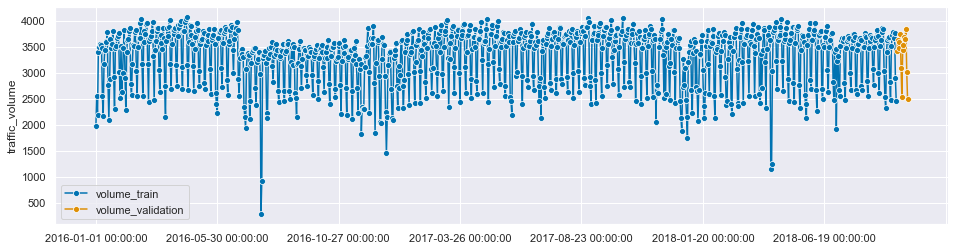

In [477]:
plot_series(df_volume_train, df_volume_validation, labels=["volume_train", "volume_validation"])

## 3.3 SARIMA

В качестве основной базовой модели построим модель SARIMA. Именно относительно полученного качества модели будем оценивать наши дальнейшие модели

In [407]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

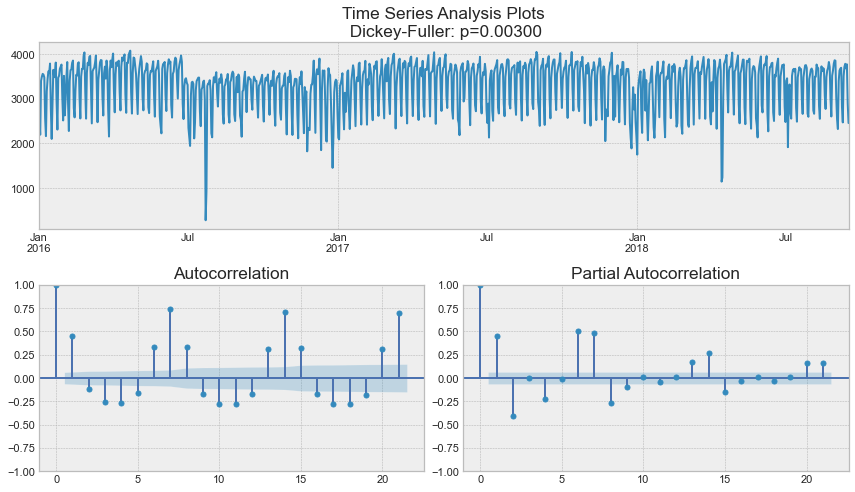

In [408]:
tsplot(df_volume_train, lags=7*3)

- Ряд по критерию Дикки-Фуллера у нас стационарен, по его графику тоже видно, что тренд, как таковой, отсутствует, т.е., матожидание постоянно, разброс вокруг среднего тоже примерно одинаковый, значит, постоянство дисперсии также наблюдается. 

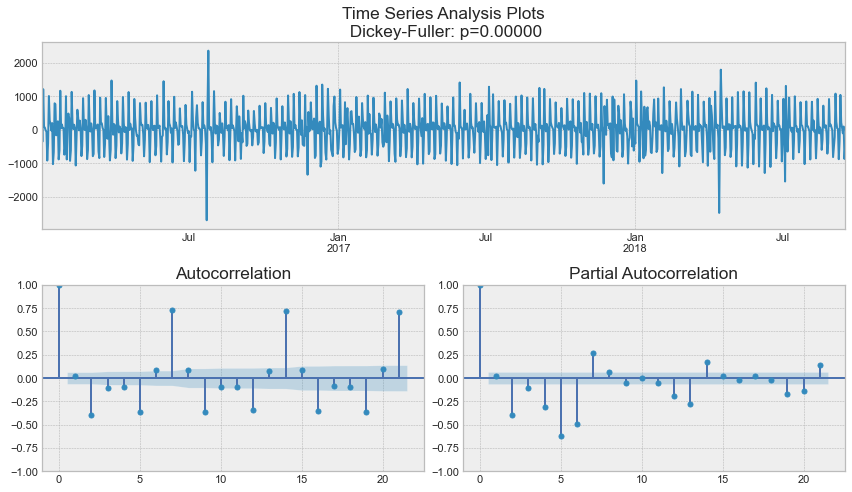

In [409]:
df_volume_train_diff = df_volume_train - df_volume_train.shift(1)
tsplot(df_volume_train_diff[1:], lags=7*3)

- Остаётся сезонность, с которой нужно разобраться перед построением модели. Для этого выполним преобразование "сезонное дифференцирование"

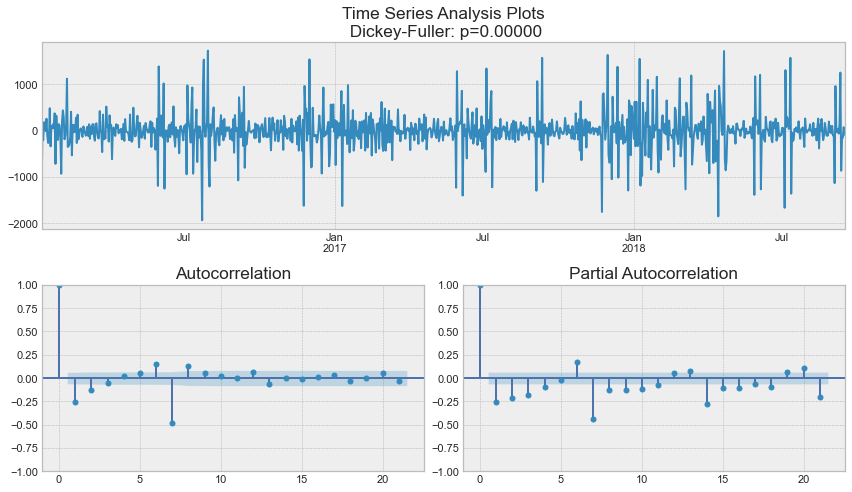

In [410]:
df_volume_train_diff = df_volume_train_diff - df_volume_train_diff.shift(7)
tsplot(df_volume_train_diff[7+1:], lags=7*3)

Уже лучше, от видимой сезонности избавились, в автокорреляционной функции по-прежнему осталось много значимых лагов, попробуем от них избавиться, взяв еще и первые разности - то есть вычитание ряда самого из себя с лагом в один шаг

Параметры модели **SARIMA**:

- $p$ - определяется при помощи графика PACF по значимому лагу, после которого большинство оставшихся лагов становятся не значимыми.

- $q$ - определяется по графику ACF по значимому лагу, после которого большинство оставшихся лагов становятся не значимыми.

- $d$ - определяется как количество обычных разностей в ряде, которые нам пришлось взять, чтобы привести его к стационарному. 

- $s$ - равна длине периода сезонности во временном ряде.

- $P$ - определяется по PACF, только смотреть нужно на число значимых лагов, кратных периоду сезонности, например, если период равен 24 и выясняется, что по PACF значим 24-й и 48-й лаг, то для начального приближения можно взять $P = 2$

- $Q$ - аналогично, но для модели скользящего среднего по сезонной компоненте, определяется по ACF

- $D$ - порядок сезонной интегрированности временного ряда. Может быть равен либо 0, либо 1, так как сезонное дифференцирование либо проводилось, либо нет

В нашем случае имеем:

- $p = 1$.
- $q = 1$
- $d = 1$
- $s = 7$

- $P = 1$
- $Q = 1$
- $D = 1$

In [411]:
from itertools import product # some useful functions
# setting initial values and some bounds for them
ps = range(0, 1)
d=1
qs = range(0, 1)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [412]:
def optimizeSARIMA(series, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(series, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [413]:
#%%time
result_table = optimizeSARIMA(df_volume_train, parameters_list, d, D, s)

  0%|          | 0/4 [00:00<?, ?it/s]

In [414]:
result_table.head()

,parameters,aic
0,"(0, 0, 1, 1)",14017.701704
1,"(0, 0, 0, 1)",14018.487520
2,"(0, 0, 1, 0)",14340.258795
3,"(0, 0, 0, 0)",14604.790190


In [415]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [416]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_volume_train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      traffic_volume   No. Observations:                  990
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -7005.851
Date:                             Mon, 26 Feb 2024   AIC                          14017.702
Time:                                     23:38:27   BIC                          14032.370
Sample:                                 01-01-2016   HQIC                         14023.282
                                      - 09-16-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.0539      0.032      1.660      0.097      -0.010       0.117
ma.S.L7       -0.9993      

Построим прогнозы на:
- на 2 дня;
- на 1 неделю;
- на 2 недели.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

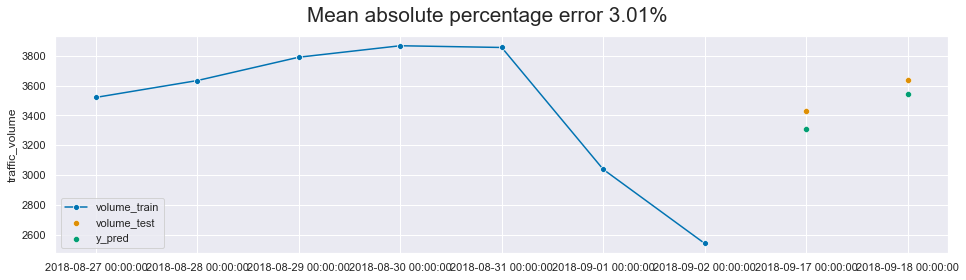

In [417]:

y_pred = best_model.get_forecast(steps=2).predicted_mean

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train_test[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

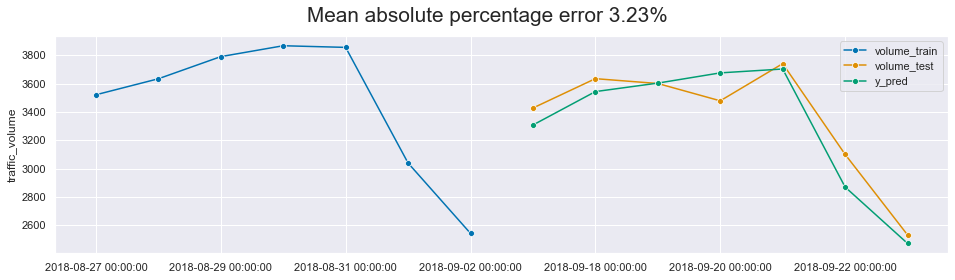

In [418]:

y_pred = best_model.get_forecast(steps=7).predicted_mean

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train_test[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

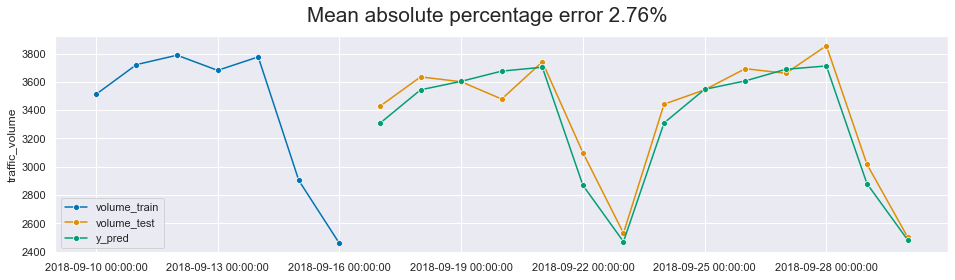

In [421]:

y_pred = best_model.get_forecast(steps=14).predicted_mean

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

**Заключение**
 - Построенная модель показала хорошее качество прогнозирования на 2 недели вперед (**2.76%**). Далее будем оценивать качество моделей относительно этого значения.

## 3.4 base_line

### ___Forecast_horizon for validation

In [478]:
forecast_horizon_2d = create_forecast_timestamp(df_volume_train, forecast_horizon=2)
forecast_horizon_1w = create_forecast_timestamp(df_volume_train, forecast_horizon=7)
forecast_horizon_2w = create_forecast_timestamp(df_volume_train, forecast_horizon=14)

In [479]:
forecast_horizon_2d = pd.Series(index=forecast_horizon_2d, name=df_volume_train.name)
forecast_horizon_1w = pd.Series(index=forecast_horizon_1w, name=df_volume_train.name)
forecast_horizon_2w = pd.Series(index=forecast_horizon_2w, name=df_volume_train.name)

### 3.4.1 Naive_model - last

In [480]:
from sktime.forecasting.naive import NaiveForecaster

In [481]:
def cv_naive_last (series_train: pd.Series, FORECAST_HORIZON: int) -> pd.Series:
    
    forecast_series = create_forecast_timestamp(series_train, forecast_horizon=FORECAST_HORIZON)
    forecast_series = pd.Series(index=forecast_series, name=series_train.name)
    
    forecaster = NaiveForecaster(strategy="last")
    forecaster.fit(series_train)
    
    predictions = forecaster.predict(forecast_series.index)
    
    return predictions

#### _2day forecasting

Last train date_time:
____________________


2018-09-11    3721.666667
2018-09-12    3788.125000
2018-09-13    3680.916667
2018-09-14    3776.000000
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-15    3776.0
2018-09-16    3776.0
Name: traffic_volume, dtype: float64

CVscore for horizon = 2:
 - mean = 16.644110779432527;
 - std = 17.91872121581364


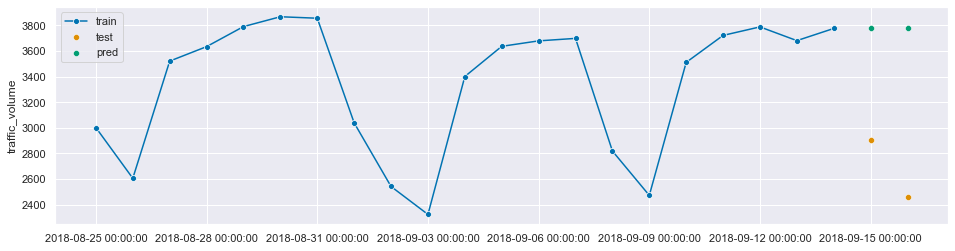

In [482]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=2, 
                  predict_function=cv_naive_last, 
                  loss_function=mean_absolute_percentage_error, 
                  plot_last=True,
                  n_splits = 3)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

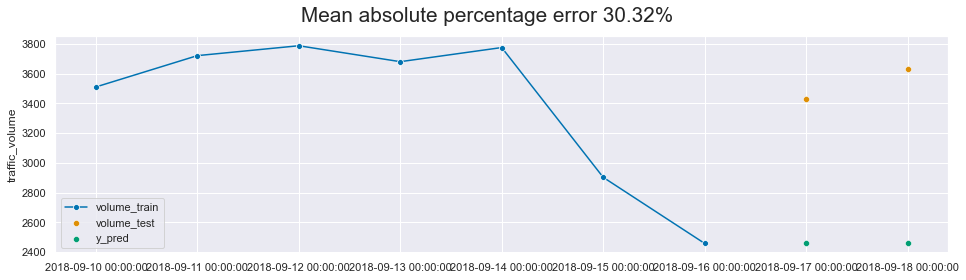

In [483]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(df_volume_train)

y_pred = forecaster.predict(forecast_horizon_2d.index)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

#### _7day forecasting

Last train date_time:
____________________


2018-09-06    3679.000000
2018-09-07    3698.416667
2018-09-08    2818.958333
2018-09-09    2472.333333
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-10    2472.333333
2018-09-11    2472.333333
2018-09-12    2472.333333
2018-09-13    2472.333333
Name: traffic_volume, dtype: float64

CVscore for horizon = 7:
 - mean = 23.21772550807455;
 - std = 2.445382794293945


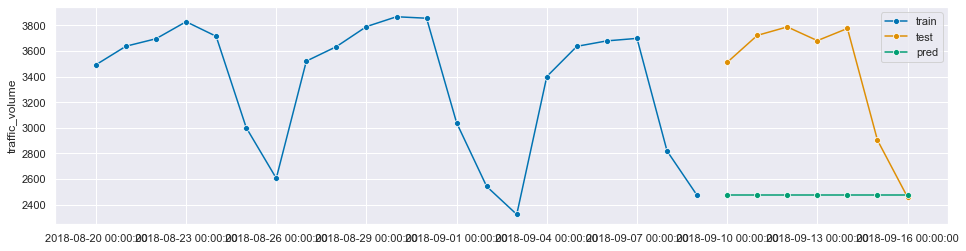

In [484]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=7, 
                  predict_function=cv_naive_last, 
                  loss_function=mean_absolute_percentage_error, 
                  plot_last=True,
                 n_splits = 3)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

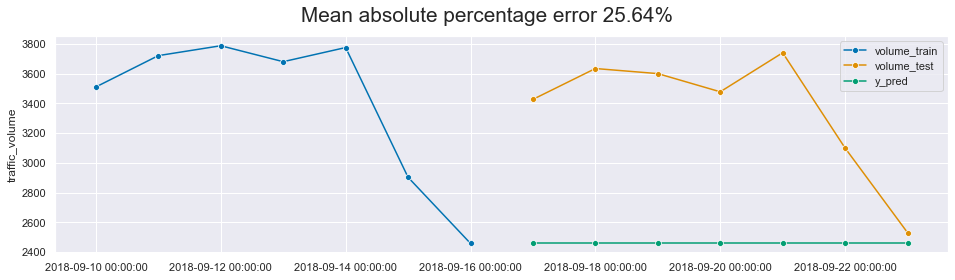

In [485]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(df_volume_train)

y_pred = forecaster.predict(forecast_horizon_1w.index)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

#### _2week forecasting

Last train date_time:
____________________


2018-08-30    3867.416667
2018-08-31    3855.833333
2018-09-01    3038.750000
2018-09-02    2541.791667
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-03    2541.791667
2018-09-04    2541.791667
2018-09-05    2541.791667
2018-09-06    2541.791667
Name: traffic_volume, dtype: float64

CVscore for horizon = 14:
 - mean = 23.481549151773304;
 - std = 3.799761990933469


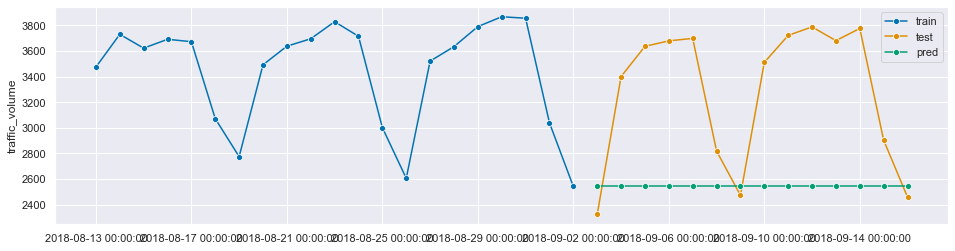

In [486]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=2*7, 
                  predict_function=cv_naive_last, 
                  loss_function=mean_absolute_percentage_error, 
                  plot_last=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

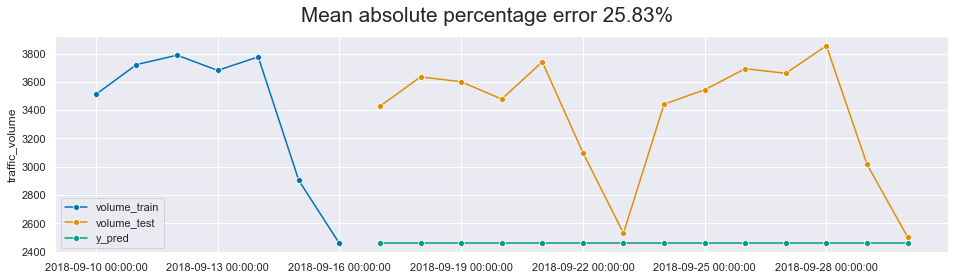

In [487]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(df_volume_train)

y_pred = forecaster.predict(forecast_horizon_2w.index)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

**Заключение**
 - Модель, построенная по принципу *следующее равно предыдущему*, очевидно оказалась неэффективной

### 3.4.2 Naive_model - last + season

In [488]:
def cv_naive_last_Seasoned (series_train: pd.Series, FORECAST_HORIZON: int) -> pd.Series:
    
    forecast_series = create_forecast_timestamp(series_train, forecast_horizon=FORECAST_HORIZON)
    forecast_series = pd.Series(index=forecast_series, name=series_train.name)
    
    forecaster = NaiveForecaster(strategy="last", sp=7)
    forecaster.fit(series_train)
    
    predictions = forecaster.predict(forecast_series.index)
    
    return predictions

#### _2day forecasting

Last train date_time:
____________________


2018-09-11    3721.666667
2018-09-12    3788.125000
2018-09-13    3680.916667
2018-09-14    3776.000000
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-15    2818.958333
2018-09-16    2472.333333
Name: traffic_volume, dtype: float64

CVscore for horizon = 2:
 - mean = 7.28127019081167;
 - std = 8.776483025437633


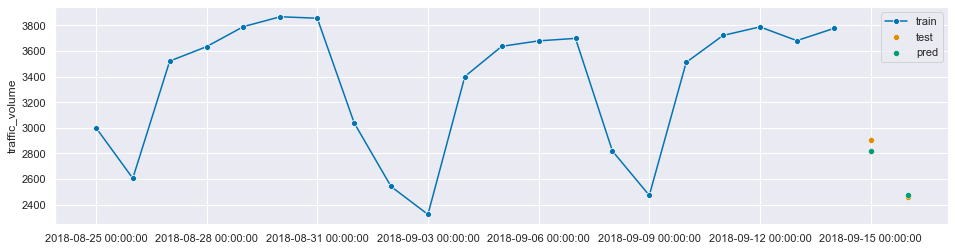

In [489]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=2, 
                  predict_function=cv_naive_last_Seasoned, 
                  loss_function=mean_absolute_percentage_error, 
                  plot_last=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

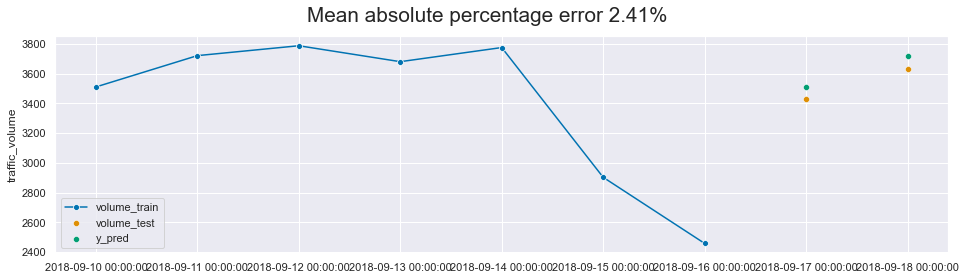

In [490]:
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(df_volume_train)

y_pred = forecaster.predict(forecast_horizon_2d.index)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

#### _7day forecasting

Last train date_time:
____________________


2018-09-06    3679.000000
2018-09-07    3698.416667
2018-09-08    2818.958333
2018-09-09    2472.333333
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-10    2323.750
2018-09-11    3400.625
2018-09-12    3636.375
2018-09-13    3679.000
Name: traffic_volume, dtype: float64

CVscore for horizon = 7:
 - mean = 4.934416294924824;
 - std = 3.795781232183713


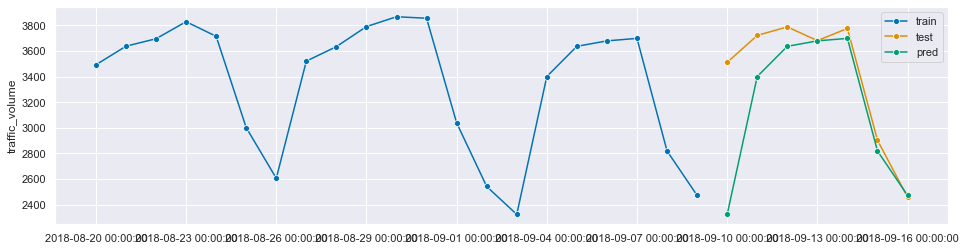

In [491]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=7, 
                  predict_function=cv_naive_last_Seasoned, 
                  loss_function=mean_absolute_percentage_error, 
                  plot_last=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

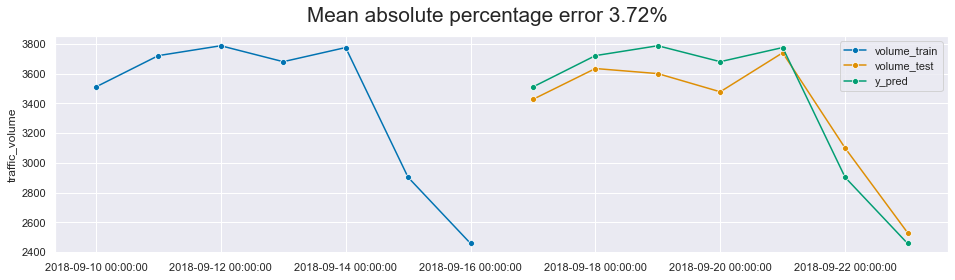

In [492]:
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(df_volume_train)

y_pred = forecaster.predict(forecast_horizon_1w.index)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

#### _2week forecasting

Last train date_time:
____________________


2018-08-30    3867.416667
2018-08-31    3855.833333
2018-09-01    3038.750000
2018-09-02    2541.791667
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-03    3521.000000
2018-09-04    3634.041667
2018-09-05    3790.541667
2018-09-06    3867.416667
Name: traffic_volume, dtype: float64

CVscore for horizon = 14:
 - mean = 6.177252141745707;
 - std = 3.7496088651256825


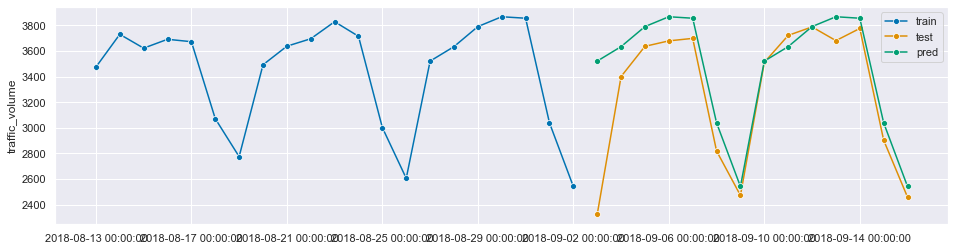

In [493]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=2*7, 
                  predict_function=cv_naive_last_Seasoned, 
                  loss_function=mean_absolute_percentage_error, 
                  plot_last=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

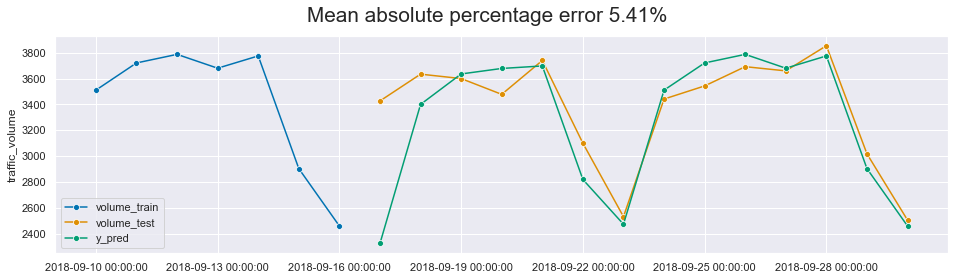

In [494]:
forecaster = NaiveForecaster(strategy="last", sp=2*7)
forecaster.fit(df_volume_train)

y_pred = forecaster.predict(forecast_horizon_2w.index)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

**Заключение**
 - Модель, построенная по принципу *следующее равно предыдущему с учетом сезонности*, показала довольно неплохое качество прогноза (**5.41% на valid** и **6.17 на CV**). Достаточно высокое качество прогнозирования такой простой моделью можно объяснить явно выраженной сезонностью временного ряда и отсутствием глобального тренда

### 3.4.3 Naive_model - mean

In [495]:
def year_mean_forecasting (series_train: pd.Series, FORECAST_HORIZON: int):
    
    y = pd.DataFrame(series_train)
    
    y["year"] = y.index.year.values
    y["month"] = y.index.month.values
    y["day"] = y.index.day.values
    #y["hour"] = y.index.hour.values
    
    #model = y.groupby(["day", "hour"])["traffic_volume"].mean()
    model = y.groupby(["day"])["traffic_volume"].mean()
    
    # добавить проверки, что все есть
    forecast_y = pd.DataFrame(FORECAST_HORIZON.copy())
    forecast_y["year"] = forecast_y.index.year.values
    forecast_y["month"] = forecast_y.index.month.values
    forecast_y["day"] = forecast_y.index.day.values
    #forecast_y["hour"] = forecast_y.index.hour.values
    forecast_yy = []
    
    for i in range(forecast_y.shape[0]):
            
        day = forecast_y.iloc[i]['day']
        #hour = forecast_y.iloc[i]['hour']
        #forecast_yy.append (model[day][hour])
        forecast_yy.append (model[day])
        
    return pd.Series(forecast_yy, index=forecast_y.index)

In [496]:
def cv_year_mean_forecasting (series_train: pd.Series, FORECAST_HORIZON: int) -> pd.Series:
    
    forecast_series = create_forecast_timestamp(series_train, forecast_horizon=FORECAST_HORIZON)
    forecast_series = pd.Series(index=forecast_series, name=series_train.name)
    predictions = year_mean_forecasting(series_train, FORECAST_HORIZON = forecast_series)
    
    return predictions

#### _2day forecasting

Last train date_time:
____________________


2018-09-11    3721.666667
2018-09-12    3788.125000
2018-09-13    3680.916667
2018-09-14    3776.000000
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-15    3347.207682
2018-09-16    3336.014974
dtype: float64

CVscore for horizon = 2:
 - mean = 16.204837805090204;
 - std = 5.472294416437318


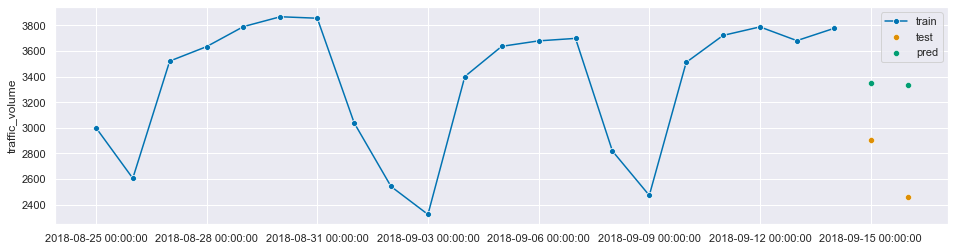

In [497]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=2, 
                  predict_function=cv_year_mean_forecasting, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

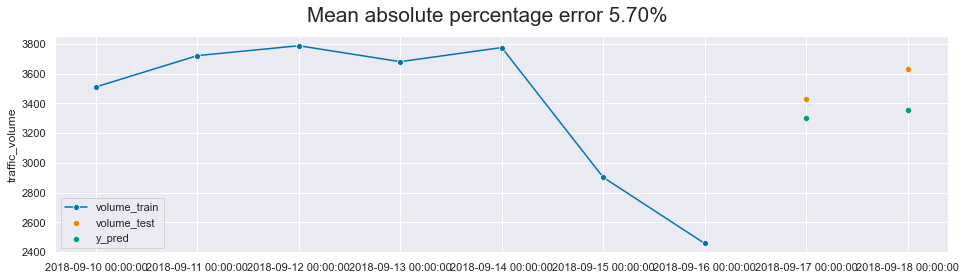

In [498]:
y_pred = year_mean_forecasting(df_volume_train, FORECAST_HORIZON = forecast_horizon_2d)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

#### _7day forecasting

Last train date_time:
____________________


2018-09-06    3679.000000
2018-09-07    3698.416667
2018-09-08    2818.958333
2018-09-09    2472.333333
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-10    3298.641927
2018-09-11    3277.496094
2018-09-12    3352.871745
2018-09-13    3366.729688
dtype: float64

CVscore for horizon = 7:
 - mean = 13.44093559657091;
 - std = 2.3639130175310576


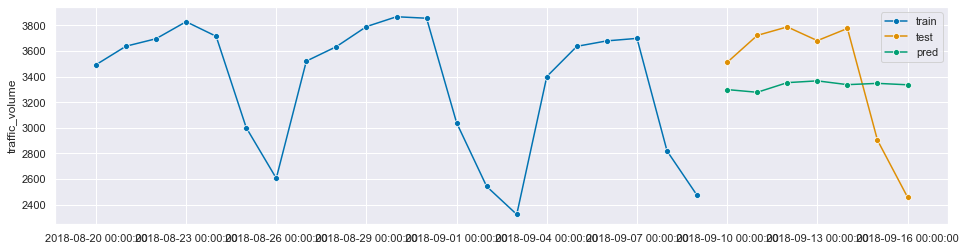

In [499]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=7, 
                  predict_function=cv_year_mean_forecasting, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

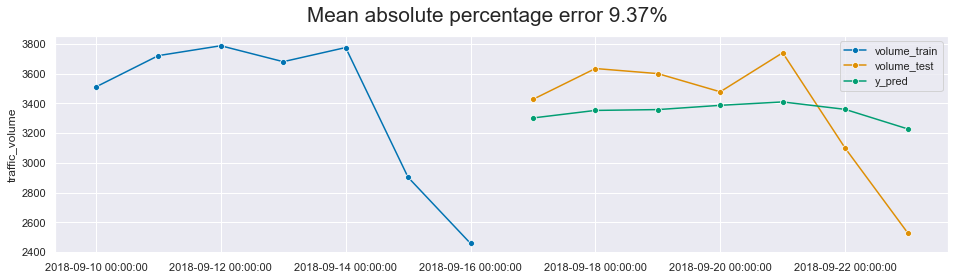

In [500]:
y_pred = year_mean_forecasting(df_volume_train, FORECAST_HORIZON = forecast_horizon_1w)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

#### _2week forecasting

Last train date_time:
____________________


2018-08-30    3867.416667
2018-08-31    3855.833333
2018-09-01    3038.750000
2018-09-02    2541.791667
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-03    3224.916667
2018-09-04    3147.176432
2018-09-05    3246.290365
2018-09-06    3351.641927
dtype: float64

CVscore for horizon = 14:
 - mean = 15.199308199550803;
 - std = 2.7950880527328383


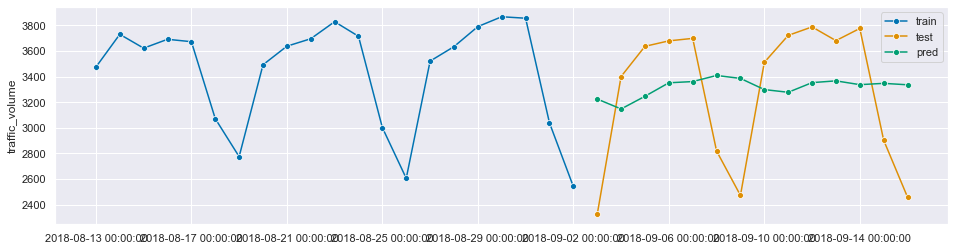

In [501]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=2*7, 
                  predict_function=cv_year_mean_forecasting, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

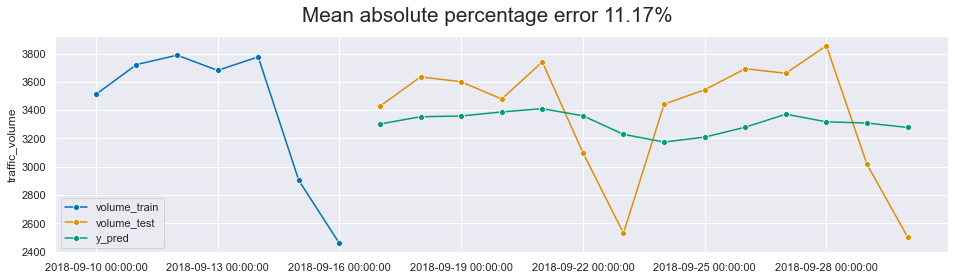

In [502]:
y_pred = year_mean_forecasting(df_volume_train, FORECAST_HORIZON = forecast_horizon_2w)

error = mean_absolute_percentage_error(df_volume_validation[:y_pred.shape[0]].values, y_pred.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(df_volume_train[-1*7:], df_volume_validation[:y_pred.shape[0]],y_pred,  labels=["volume_train", "volume_test", 'y_pred'], title=title)

## 3.5 ML_models

#### ___Функции генерации признаков

In [503]:
def create_time_features(series: pd.Series) -> pd.DataFrame:
    data = pd.DataFrame(series).copy()
#     data["hour"] = data.index.hour.values
#     data['hour_cos'] = np.cos(2 * np.pi * data["hour"].values / 23)
#     data['hour_sin'] = np.sin(2 * np.pi * data["hour"].values / 23)
    data["day"] = data.index.weekday.values
    data['day_cos'] = np.cos(2 * np.pi * data["day"].values / 6)
    data['day_sin'] = np.sin(2 * np.pi * data["day"].values / 6)
    data["is_weekend"] = data.index.weekday.isin([5,6]).astype(int) # Выходные или праздничные дни
    return data

In [504]:
class LagEncoder:
    def __init__(self, start_lag, end_lag):
        self.start_lag = start_lag
        self.end_lag = end_lag
        self.lag_columns = []
        for i in range(self.start_lag, self.end_lag+1):
            col_name = "lag_{}".format(i)
            self.lag_columns.append(col_name)
    
    def get_lags(self, series):
        df_lags = pd.DataFrame(index=series.index)
        for idx, i in enumerate(range(self.start_lag, self.end_lag+1)):
            col_name = self.lag_columns[idx]
            df_lags[col_name] = series.shift(i)
        return df_lags

In [505]:
def add_features (series: pd.Series, get_lags=True, get_date_time=True) -> tuple:
    df_series = pd.DataFrame(series)
    df_series.index = pd.to_datetime(df_series.index)
    
    df_lags_f = pd.DataFrame()
    df_time_f = pd.DataFrame()
    lags_columns = []
    
    # Добавление Лагов
    if get_lags is True:
        lag_encoder = LagEncoder(7,7)
        df_lags_f_1 = lag_encoder.get_lags(df_series)
        
        lag_encoder = LagEncoder(7*2,7*2)
        df_lags_f_2 = lag_encoder.get_lags(df_series)
        
        lag_encoder = LagEncoder(7*3,7*3)
        df_lags_f_3 = lag_encoder.get_lags(df_series)
        
        df_lags_f = pd.concat([df_lags_f_1, df_lags_f_2, df_lags_f_3], axis=1)

        
        lags_columns = list(df_lags_f.columns)
        
    if get_date_time is True:
        df_time_f = create_time_features(df_series)[['day_cos', 'day_sin', 'is_weekend']]
        

    data = pd.concat([df_series, df_lags_f, df_time_f], axis=1)
    data.dropna(subset=lags_columns, inplace=True)
    
    # Разделение на X и Y
    feat_cols = data.columns.tolist()[1:]
    y = data[series.name]
    X = data[feat_cols]
    
    return y, X

#### ___Функции рекурентного прогнозирвания

In [506]:
# Имеется вопрос с временными индексами для формирования временных признаков
# В forecast_start_X нулевой индекс д.б первым из прогнозируемых (следущим после последнего y_train)

def get_forecast_X (extended_time_series:pd.Series):
    
    Y, forecast_X = add_features(extended_time_series, get_lags=True)
    
    return forecast_X.iloc[[-1]]

In [507]:
# Прогноз модели

def recurent_forecasting (y_train: pd.Series, 
                          FORECAST_HORIZON: int, 
                          fitted_model, 
                          step_display=False):

    # добавить проверки, что все есть
    t_index = create_forecast_timestamp(y_train, forecast_horizon=FORECAST_HORIZON)
    forecast_y = pd.Series(index=t_index, name=y_train.name)

    forecast_X = pd.DataFrame()

    for i in range(FORECAST_HORIZON):
        
            
        extended_y = pd.concat([y_train, forecast_y.iloc[range(i+1)]])
        forecast_X = pd.concat([forecast_X, get_forecast_X(extended_y)])

        forecast_y.iloc[[i]] = fitted_model.predict(forecast_X.iloc[[-1]])
        
    if step_display is True:
        display(forecast_X)
        display(forecast_y)
        
    return forecast_y

In [508]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def get_model_pipe(X_train: pd.DataFrame, model) -> Pipeline:
    
    date_time_cols = ['hour_cos', 'hour_sin', 'is_weekend']
    lags_cols = [i for i in X_train.columns if i not in date_time_cols]

    lags_pipe = Pipeline([('scaler', StandardScaler()),
                         ])

    transformers = [("lags", lags_pipe, lags_cols),
                   ]

    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

    model_pipe = Pipeline(steps=[
        ('Preprocessor', preprocessor),
        ('Model',        model)
    ])
    
    return model_pipe

In [509]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def get_preprocessor_pipe(X_train: pd.DataFrame) -> Pipeline:
    
    date_time_cols = ['day_cos', 'day_sin', 'is_weekend']
    lags_cols = [i for i in X_train.columns if i not in date_time_cols]

    lags_pipe = Pipeline([('scaler', StandardScaler()),
                         ])

    transformers = [("lags", lags_pipe, lags_cols),
                   ]

    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

    
    return preprocessor

In [572]:
# Прогноз модели

def recurent_forecasting_noised (y_train: pd.Series, FORECAST_HORIZON: int, fitted_model, noise_std, step_display=False):

    # добавить проверки, что все есть
    t_index = create_forecast_timestamp(y_train, forecast_horizon=FORECAST_HORIZON)
    forecast_y = pd.Series(index=t_index, name=y_train.name)

    forecast_X = pd.DataFrame()

    for i in range(FORECAST_HORIZON):
        
        if step_display is True:
            display(forecast_X)
            display(forecast_y)
            
        extended_y = pd.concat([y_train, forecast_y.iloc[range(i+1)]])
        forecast_X = pd.concat([forecast_X, get_forecast_X(extended_y)])

        forecast_y.iloc[[i]] = fitted_model.predict(forecast_X.iloc[[-1]]) + np.random.normal(0, noise_std)
        
        
    return forecast_y

In [573]:
def sample_bootstrap_forecasts (y_train: pd.Series, FORECAST_HORIZON: int, fitted_model, noise_std, n_samples, step_display=False):    
    df_conf_int = pd.DataFrame()
    
    for s in tqdm_notebook(range(n_samples)):
        df_forecasted = recurent_forecasting_noised(y_train=y_train, 
                                                    FORECAST_HORIZON=FORECAST_HORIZON, fitted_model=fitted_model, noise_std=noise_std)
        df_conf_int["forcast_{}".format(s)] = df_forecasted.values
    
    df_conf_int.index = df_forecasted.index
    return df_conf_int.std(axis=1)

In [576]:
def get_train_forecast_errors_v2(y_test, y_pred):
    errors = (y_test - y_pred)
    return errors

### 2.1 Линейная модель

#### 2.1.1 Базовая модель

В качестве базовой модели будем использовать **Ridge регрессию**, которая позволяет контролировать веса с целью предупреждения переобучения 

In [510]:
def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [511]:
y_train, X_train = add_features(df_volume_train, 
                                get_lags=True,
                                get_date_time=True)

display(X_train.head(3))

,lag_7,lag_14,lag_21,day_cos,day_sin,is_weekend
2016-01-22,3793.395833,3484.000000,1973.208333,-0.5,-8.660254e-01,0
2016-01-23,2766.937500,2563.854167,2556.895833,0.5,-8.660254e-01,1
2016-01-24,2102.375000,2165.354167,2196.916667,1.0,-2.449294e-16,1


In [512]:
preprocessor = get_preprocessor_pipe(X_train)
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=X_train.columns)
display(X_train.head(3))

,lag_7,lag_14,lag_21,day_cos,day_sin,is_weekend
0,0.888220,0.313995,-2.475323,-0.5,-8.660254e-01,0.0
1,-1.017116,-1.394624,-1.395549,0.5,-8.660254e-01,1.0
2,-2.250692,-2.134599,-2.061481,1.0,-2.449294e-16,1.0


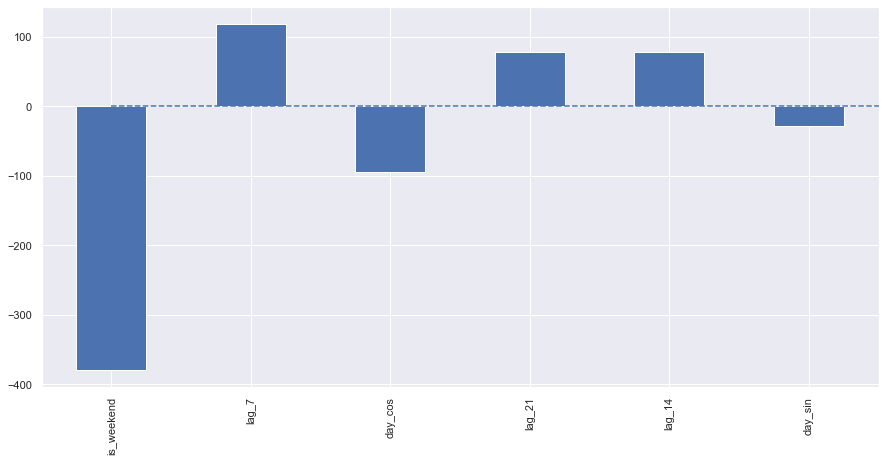

In [513]:
model = Ridge()
model.fit(X_train, y_train)
plotCoefficients(model=model, X_train=X_train)

#### 2.1.2 CV modeling

In [514]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression

def cv_lr_lags (series_train: pd.Series, FORECAST_HORIZON: int) -> pd.Series:
    
    y_train, X_train = add_features(series_train, 
                                    get_lags=True, get_date_time=True)

    model = get_model_pipe(X_train, model=Ridge())
    model.fit(X_train, y_train)
    
    
    predictions = recurent_forecasting(y_train=y_train, 
                                       FORECAST_HORIZON=FORECAST_HORIZON, 
                                       fitted_model=model,
                                       step_display=False)
    
    return predictions

Last train date_time:
____________________


2018-09-11    3721.666667
2018-09-12    3788.125000
2018-09-13    3680.916667
2018-09-14    3776.000000
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-15    2844.597566
2018-09-16    2568.966576
Name: traffic_volume, dtype: float64

CVscore for horizon = 2:
 - mean = 3.9544768529822347;
 - std = 2.216350113722124


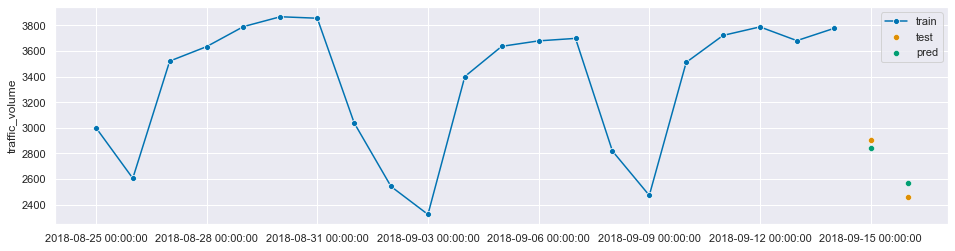

In [515]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=2, 
                  predict_function=cv_lr_lags, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True,
                  n_splits=5)

Last train date_time:
____________________


2018-09-06    3679.000000
2018-09-07    3698.416667
2018-09-08    2818.958333
2018-09-09    2472.333333
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-10    3175.007964
2018-09-11    3475.104002
2018-09-12    3654.015221
2018-09-13    3765.954585
Name: traffic_volume, dtype: float64

CVscore for horizon = 7:
 - mean = 4.712318901916001;
 - std = 2.4260639736290126


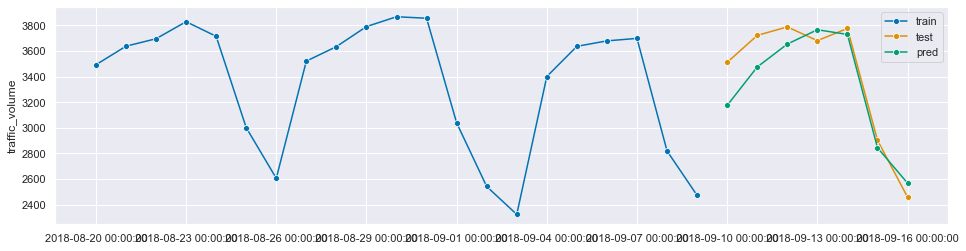

In [516]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=7, 
                  predict_function=cv_lr_lags, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True,
                  n_splits=5)

Last train date_time:
____________________


2018-08-30    3867.416667
2018-08-31    3855.833333
2018-09-01    3038.750000
2018-09-02    2541.791667
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-03    3442.364615
2018-09-04    3545.012240
2018-09-05    3664.846128
2018-09-06    3782.546690
Name: traffic_volume, dtype: float64

CVscore for horizon = 14:
 - mean = 3.7386812452461493;
 - std = 1.347055930712892


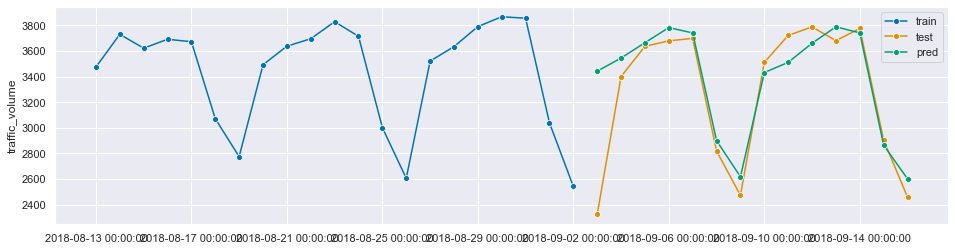

In [517]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=7*2, 
                  predict_function=cv_lr_lags, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True,
                  n_splits=5)

#### 2.1.3 Проверка на отложенной выборке с построением доверительных интервалов

Сначала сформируем модель с препроцессингом и обучим на train

In [588]:
y_train, X_train = add_features(df_volume_train, 
                                get_lags=True,
                                get_date_time=True)

model = get_model_pipe(X_train, Ridge())
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('lags',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_7', 'lag_14', 'lag_21',
                                                   'day_cos', 'day_sin'])])),
                ('Model', Ridge())])

Для оценки потенциального разброса ошибок, оценим качество рекурентного предсказания на части train выборки

In [589]:
forecasted_train_y = recurent_forecasting(y_train=y_train[:-14], 
                                          FORECAST_HORIZON=(y_train[-14:].shape[0]), 
                                          fitted_model=model)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

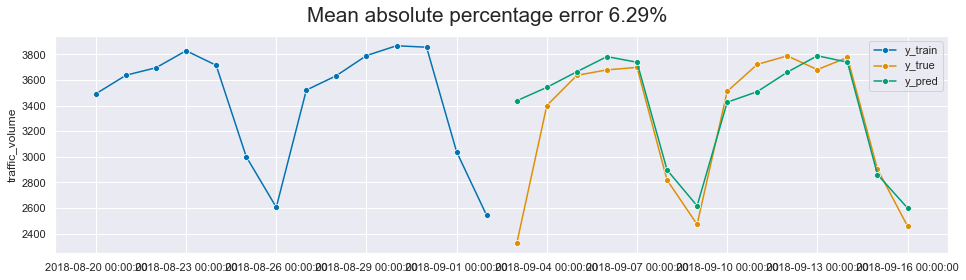

In [590]:
error = mean_absolute_percentage_error(y_train[-14:].values, forecasted_train_y.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(y_train[-14*2:-14], y_train[-14:],  forecasted_train_y, labels=["y_train",'y_true', "y_pred"], title=title)

In [591]:
# Оценка ошибки
errors = get_train_forecast_errors_v2(y_train[-14:], forecasted_train_y)
errors.std()

312.01795763139313

Теперь можем построить прогноз на две недли вперед и проверить качество на отложенной выборке, которая не участвовала ни в обучении, ни в оценке доверительных интервалов

In [592]:
# Прогнозирование и Формирование доверительных интервалов
forecasted_y = recurent_forecasting(y_train=y_train, FORECAST_HORIZON=14, fitted_model=model)
conf_std = sample_bootstrap_forecasts(y_train=y_train, FORECAST_HORIZON=14, fitted_model=model, noise_std=errors.std(), n_samples=7)

  0%|          | 0/7 [00:00<?, ?it/s]

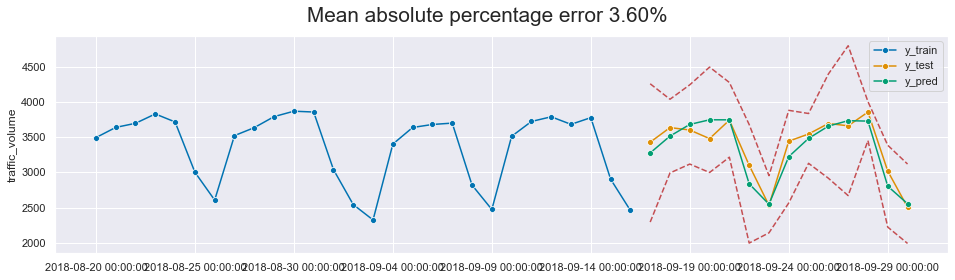

In [593]:
scale = 1.96
extended_y = pd.concat([y_train[-14*2:], forecasted_y])

lower = extended_y - scale * conf_std
upper = extended_y + scale * conf_std


error = mean_absolute_percentage_error(df_volume_validation.values, forecasted_y.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(y_train[-14*2:], df_volume_validation, forecasted_y, labels=["y_train", "y_test", "y_pred"], title=title)
plt.plot(lower.values, "r--", alpha=1)
plt.plot(upper.values, "r--", alpha=1)

### 2.2 Градиентный бустинг

#### 2.2.1 Базовая модель

In [518]:
def plotCoefficients_gb(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.feature_importances_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [519]:
y_train, X_train = add_features(df_volume_train, 
                                get_lags=True,
                                get_date_time=True)

display(X_train.head(3))

,lag_7,lag_14,lag_21,day_cos,day_sin,is_weekend
2016-01-22,3793.395833,3484.000000,1973.208333,-0.5,-8.660254e-01,0
2016-01-23,2766.937500,2563.854167,2556.895833,0.5,-8.660254e-01,1
2016-01-24,2102.375000,2165.354167,2196.916667,1.0,-2.449294e-16,1


In [520]:
preprocessor = get_preprocessor_pipe(X_train)
X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
display(X_train.head(3))

,0,1,2,3,4,5
0,0.888220,0.313995,-2.475323,-0.5,-8.660254e-01,0.0
1,-1.017116,-1.394624,-1.395549,0.5,-8.660254e-01,1.0
2,-2.250692,-2.134599,-2.061481,1.0,-2.449294e-16,1.0


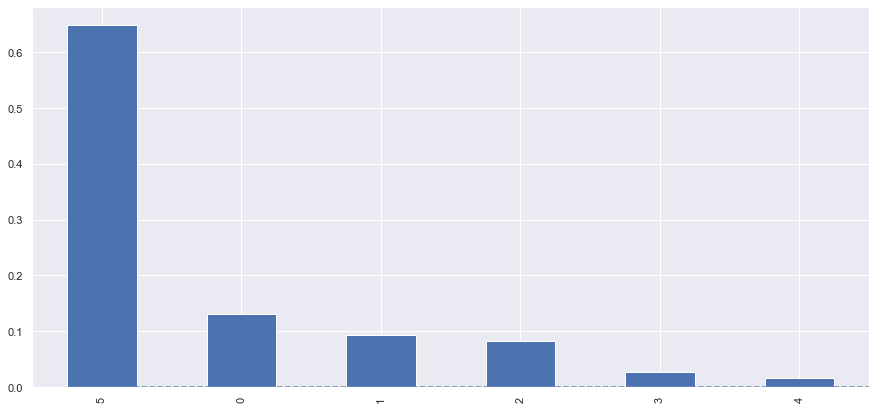

In [521]:
model = GradientBoostingRegressor(n_estimators=100, alpha=0.1)
model.fit(X_train, y_train)
plotCoefficients_gb(model=model, X_train=X_train)

#### 2.2.2 CV modeling

In [522]:
def cv_gb_lags (series_train: pd.Series, FORECAST_HORIZON: int) -> pd.Series:
    
    y_train, X_train = add_features(series_train, 
                                    get_lags=True,
                                    get_date_time=True)
    

    model = get_model_pipe(X_train, model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1))
    model.fit(X_train, y_train)
    
    predictions = recurent_forecasting(y_train=y_train, 
                                       FORECAST_HORIZON=FORECAST_HORIZON, 
                                       fitted_model=model)
    
    return predictions

Last train date_time:
____________________


2018-09-11    3721.666667
2018-09-12    3788.125000
2018-09-13    3680.916667
2018-09-14    3776.000000
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-15    2944.983291
2018-09-16    2610.433395
Name: traffic_volume, dtype: float64

CVscore for horizon = 2:
 - mean = 3.5212127065780385;
 - std = 1.3849952705382214


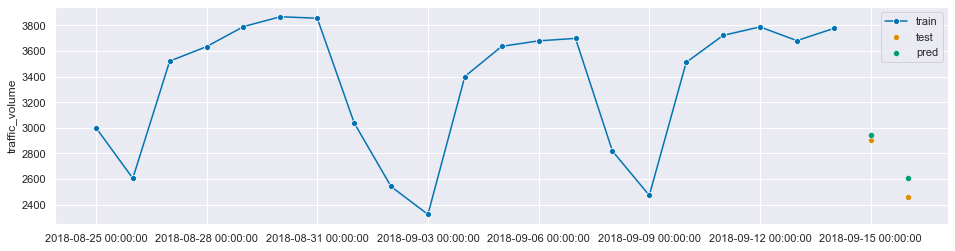

In [523]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=2, 
                  predict_function=cv_gb_lags, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True,
                  n_splits=5)

Last train date_time:
____________________


2018-09-06    3679.000000
2018-09-07    3698.416667
2018-09-08    2818.958333
2018-09-09    2472.333333
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-10    3503.983074
2018-09-11    3491.201461
2018-09-12    3646.011979
2018-09-13    3723.114168
Name: traffic_volume, dtype: float64

CVscore for horizon = 7:
 - mean = 4.500899568302755;
 - std = 2.5831864329977634


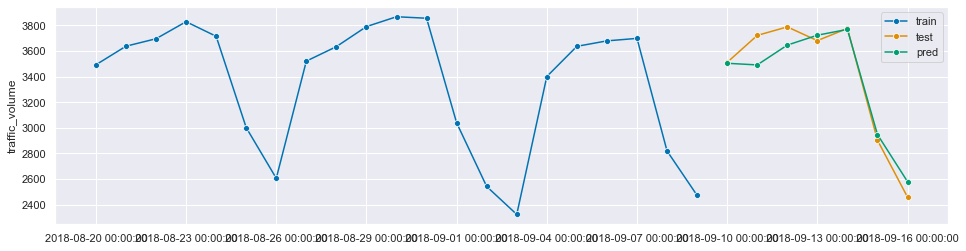

In [524]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=1*7, 
                  predict_function=cv_gb_lags, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True,
                  n_splits=5)

Last train date_time:
____________________


2018-08-30    3867.416667
2018-08-31    3855.833333
2018-09-01    3038.750000
2018-09-02    2541.791667
Freq: D, Name: traffic_volume, dtype: float64

First predict date_time:
____________________


2018-09-03    3337.974426
2018-09-04    3580.054179
2018-09-05    3734.963735
2018-09-06    3714.764568
Name: traffic_volume, dtype: float64

CVscore for horizon = 14:
 - mean = 4.15482741882048;
 - std = 1.1710990221518878


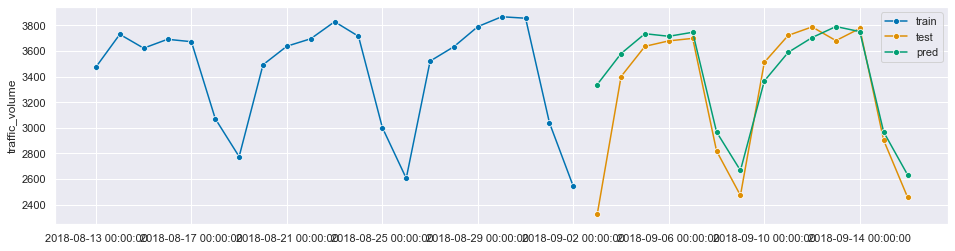

In [525]:
timeseriesCVscore(df_volume_train, 
                  FORECAST_HORIZON=7*2, 
                  predict_function=cv_gb_lags, 
                  loss_function=mean_absolute_percentage_error,
                  plot_last=True,
                  n_splits=5)

#### 2.2.3 Проверка на отложенной выборке с построением доверительных интервалов

Сначала сформируем модель с препроцессингом и обучим на train

In [569]:
y_train, X_train = add_features(df_volume_train, 
                                get_lags=True,
                                get_date_time=True)

model = get_model_pipe(X_train, GradientBoostingRegressor(n_estimators=100, alpha=0.1))
model.fit(X=X_train, y=y_train)

Для оценки потенциального разброса ошибок, оценим качество рекурентного предсказания на части train выборки

In [574]:
forecasted_train_y = recurent_forecasting(y_train=y_train[:-14], 
                                          FORECAST_HORIZON=(y_train[-14:].shape[0]), 
                                          fitted_model=model)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='traffic_volume'>)

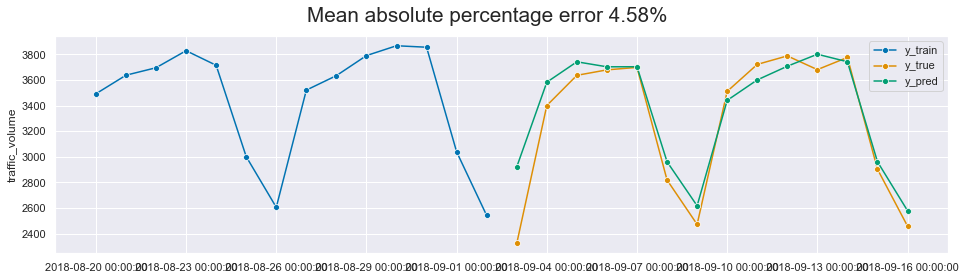

In [575]:
error = mean_absolute_percentage_error(y_train[-14:].values, forecasted_train_y.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(y_train[-14*2:-14], y_train[-14:],  forecasted_train_y, labels=["y_train",'y_true', "y_pred"], title=title)

In [577]:
# Оценка ошибки
errors = get_train_forecast_errors_v2(y_train[-14:], forecasted_train_y)
errors.std()

175.62173308629752

Теперь можем построить прогноз на две недли вперед и проверить качество на отложенной выборке, которая не участвовала ни в обучении, ни в оценке доверительных интервалов

In [579]:
# Прогнозирование и Формирование доверительных интервалов
forecasted_y = recurent_forecasting(y_train=y_train, FORECAST_HORIZON=14, fitted_model=model)
conf_std = sample_bootstrap_forecasts(y_train=y_train, FORECAST_HORIZON=14, fitted_model=model, noise_std=errors.std(), n_samples=7)

  0%|          | 0/7 [00:00<?, ?it/s]

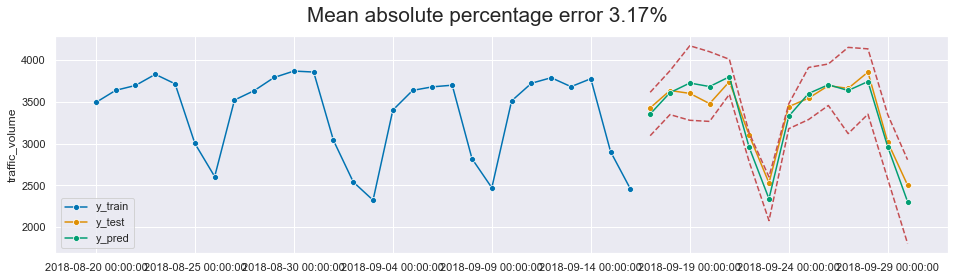

In [586]:
scale = 1.96
extended_y = pd.concat([y_train[-14*2:], forecasted_y])

lower = extended_y - scale * conf_std
upper = extended_y + scale * conf_std


error = mean_absolute_percentage_error(df_volume_validation.values, forecasted_y.values)
title = "Mean absolute percentage error {0:.2f}%".format(error)
plot_series(y_train[-14*2:], df_volume_validation, forecasted_y, labels=["y_train", "y_test", "y_pred"], title=title)
plt.plot(lower.values, "r--", alpha=1)
plt.plot(upper.values, "r--", alpha=1)